In [713]:
!git clone https://github.com/tctianchi/pyvenn.git --q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyvenn import venn
import re
from pathlib import os
from glob import glob
from typing import Literal

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import metrics
import plotnine as pn

In [7]:
%matplotlib inline

In [8]:
expression_data = pd.read_csv('glioma_cancer_exprs.csv', index_col=0)
metadata = pd.read_csv('glioma_cancer_metadata.csv')

In [9]:
!ls G*vs*.csv

G1vsG2_DGE_result.csv
G2vsG3_DGE_result.csv
G3vsG4_DGE_result.csv


In [10]:
# load differential genes for each grade comparison
grade_dge_results = glob('G*vs*G*.csv')

In [11]:
# getting differential genes
selected_genes = []
for i in grade_dge_results:
    selected_genes.extend(pd.read_csv(i, index_col=0).index.tolist())

selected_genes = list(set(selected_genes))

In [12]:
len(selected_genes)

8244

In [13]:
# selecting genes in expression data
expression_data = expression_data.loc[selected_genes,:]

In [14]:
# transpose expression data
expression_data = expression_data.T

In [15]:
# checking if positions of samples in metadata corresponds with that in expression data
all(metadata.sample_id == expression_data.index)

True

In [16]:
metadata.head()

,sample_id,tumor_class,tumor_grade,gse_id,tumor_type
0,GSM3242216,glioblastoma,G4,GSE116520,malignant
1,GSM3242217,glioblastoma,G4,GSE116520,malignant
2,GSM3242218,glioblastoma,G4,GSE116520,malignant
3,GSM3242219,glioblastoma,G4,GSE116520,malignant
4,GSM3242220,glioblastoma,G4,GSE116520,malignant


In [17]:
# filter out normal samples
cancer_samples = metadata.query('tumor_grade != "Normal"').sample_id.tolist()

In [18]:
expression_data = expression_data.loc[cancer_samples,:]
metadata = metadata.query(f'sample_id in {cancer_samples}')

__Visualise gene expressions by tumour grade__

- Using PCA decomposition

In [19]:
pca = PCA(random_state=42, svd_solver='full')
X_pca = pca.fit_transform(expression_data)

In [20]:
# variance ratio
exp_var = pca.explained_variance_ratio_

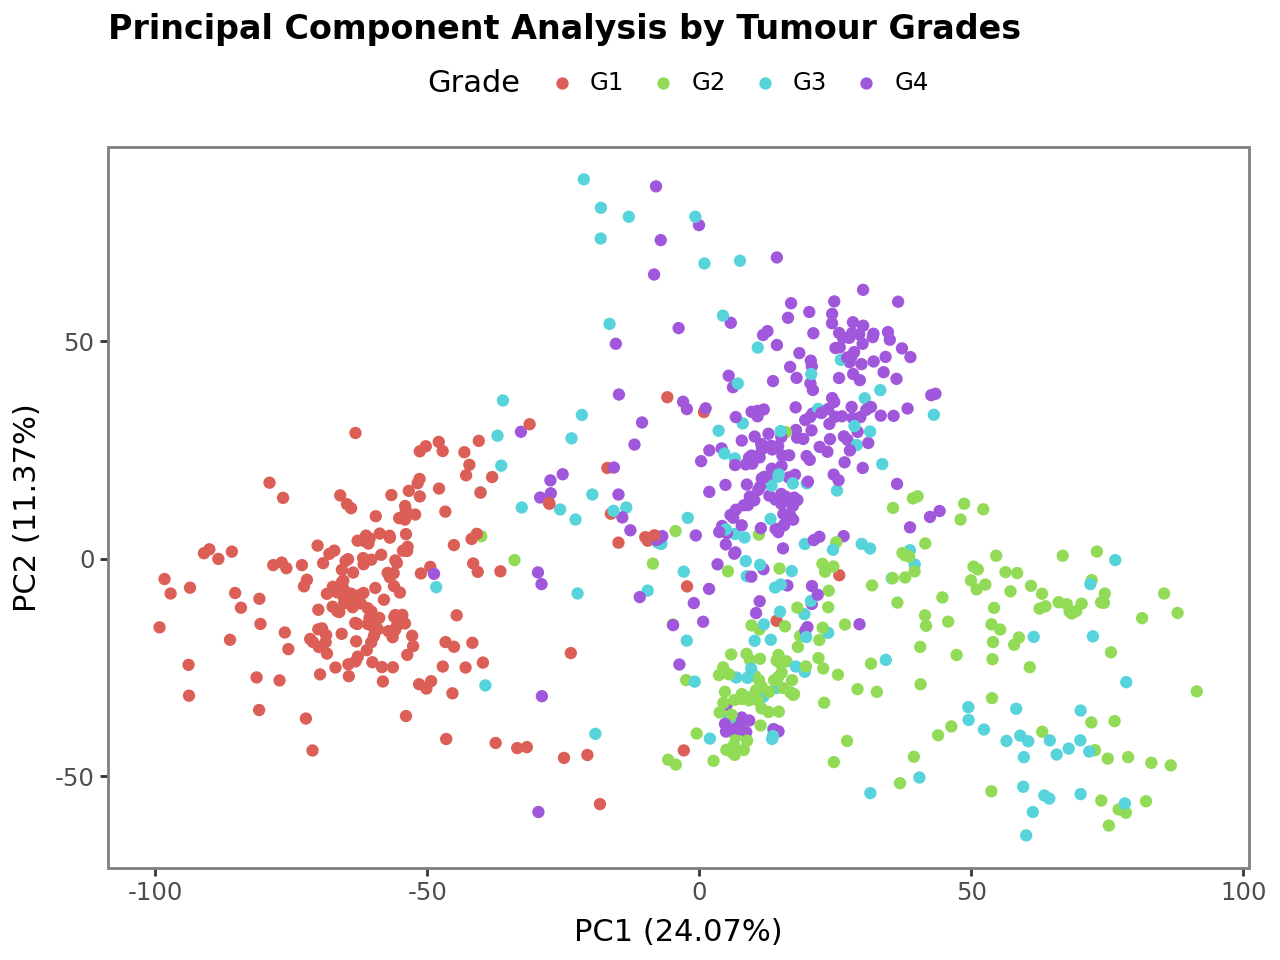

In [21]:
(
    pn.ggplot(pd.concat([
        pd.DataFrame(X_pca[:,:2], columns=['PC1', 'PC2']),
        metadata.tumor_grade.reset_index(drop=True)
    ], axis=1), 
              pn.aes('PC1', 'PC2', color='tumor_grade')) +
    pn.geom_point() +
    pn.theme_bw() +
    pn.theme(panel_grid=pn.element_blank(), 
             plot_title=pn.element_text(face='bold', size=12, hjust=0),
             legend_position= 'top',
             legend_key=pn.element_blank()) + 
    pn.labs(title='Principal Component Analysis by Tumour Grades', 
            x = f'PC1 ({exp_var[0]*100:.2f}%)',
            y = f'PC2 ({exp_var[1]*100:.2f}%)',
            color='Grade')
)

In [22]:
metadata.tumor_grade.value_counts().sort_index()

tumor_grade
G1    198
G2    166
G3    127
G4    235
Name: count, dtype: int64

### __Splitting into train and test__

In [23]:
# get target class
target_var = metadata.tumor_grade

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(expression_data, 
                                                target_var, 
                                                test_size=0.25,
                                                stratify=target_var,
                                                random_state=43)

__Helper functions__

In [25]:
[i for i in metrics.get_scorer_names() if 'roc' in i or 'f1' in i]

['f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted']

In [26]:
def tune_parameters(model, X, y, param_grid, scorer='roc_auc_ovr_weighted', cv=5):
    gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scorer)
    gcv.fit(X, y)
    return gcv

In [ ]:
def specificity(preds, 
                actual, 
                unique_class=None, 
                average_type:Literal['weighted','micro', 'macro']='weighted'):
        # class specificity tn / (tn+fp)
        if unique_class is None:
             unique_class = sorted(np.unique(actual))
        tn = np.array([np.sum((preds != i) & (actual != i)) for i in sorted(unique_class)])
        fp = np.array([np.sum((preds != i) & (actual == i)) for i in sorted(unique_class)])
        score = tn / (tn+fp)
        class_counts = np.array([np.sum(actual==i) for i in sorted(unique_class)])
        
        if average_type == 'weighted':
            return np.average(score, weights=class_counts)
        elif average_type == 'macro':
            return np.mean(score)
        elif average_type == 'micro':
             return np.sum(tn) / np.sum(tn+fp)
        else:
             print(f'{average_type} not valid')
             exit(1)

In [28]:
def print_classification_report(model, X, y):
    preds = model.predict(X)
    print(metrics.classification_report(y, preds))

def eval_metrics(model, X, y, average_type='weighted'):
    preds = model.predict(X)
    unique_class = np.unique(preds)
    probs = model.predict_proba(X)
    acc = np.mean(y == preds)
    auc = metrics.roc_auc_score(y, probs, multi_class='ovr', average=average_type)
    rec = metrics.recall_score(y, preds, average=average_type)
    prec = metrics.precision_score(y, preds, average=average_type)
    f1 = metrics.f1_score(y, preds, average=average_type)
    spec = specificity(preds, y, unique_class, average_type)

    scores = pd.DataFrame([acc, auc, rec, prec, f1, spec], 
                          columns=['scores'], 
                          index=['Accuracy', 'AUC', 'Recall', 
                                 'Precision', 'F1', 'Specificity'])
    return scores.T

In [29]:
def performance_chart_report(model, x, y):
    uniq_class = sorted(set(y))
    probas = model.predict_proba(x)
    preds = model.predict(x)
    cm = pd.DataFrame(metrics.confusion_matrix(y, preds), index=uniq_class, columns=uniq_class)
    fig, ax = plt.subplots(1, 3, figsize=(11,4.3))
    for i in range(len(uniq_class)):
        y_clas = np.where(y == uniq_class[i], 1, 0)
        auc = metrics.roc_auc_score(y_clas, probas[:,i])
        pr_score = metrics.average_precision_score(y_clas, probas[:,i])
        precision, recall, _ = metrics.precision_recall_curve(y_clas, probas[:,i])
        fpr, tpr, _ = metrics.roc_curve(y_clas, probas[:,i])
        ax[0].plot(fpr, tpr, label=uniq_class[i] + f' (AUC={auc:.2f})')
        ax[1].plot(recall, precision, label=uniq_class[i] + f' (PR={pr_score:.2f})')
        ax[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
        ax[0].set_title('ROC curve', fontsize=10)
        ax[1].set(xlabel='Recall', ylabel='Precision')
        ax[1].set_title('Precision-Recall curve', fontsize=10)
    
    sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, ax=ax[2], linecolor='k', square=True)
    ax[2].set_yticklabels(uniq_class, rotation=0)
    ax[2].set(xlabel='Predicted Class', ylabel='Actual Class')
    ax[2].set_title('Confusion matrix', fontsize=10)
    
    fig.suptitle(model.__class__.__name__, fontweight='bold', x=0.12)
    fig.tight_layout()
    
    ax[0].legend(loc='lower right')
    ax[1].legend(loc='lower left')

In [30]:
def topn_importance(model, coef_num =None, topn=20):
    if hasattr(model, 'coef_'):
        varimp = model.coef_.squeeze()[coef_num]
        varimp = pd.Series(varimp, model.feature_names_in_).abs()
    elif hasattr(model, 'feature_importances_'):
        varimp = model.feature_importances_
        varimp = pd.Series(varimp, model.feature_names_in_)

    if topn is not None:
        varimp = varimp.nlargest(topn)
    varimp = varimp[varimp != 0] 
    varimp = varimp.reset_index(name='scores')
    varimp = varimp.rename(columns={'index':'gene'})

    fig = (
        pn.ggplot(varimp, pn.aes('reorder(gene, scores)', 'scores')) +
        pn.geom_col(fill='indianred') +
        pn.geom_text(pn.aes(label='scores'), fontweight='bold', size=8, 
                     format_string='{:.3f}', color='white', 
                     nudge_y=-max(varimp.iloc[:, 1])*0.05) + 
        pn.theme_bw() +
        pn.theme(panel_grid=pn.element_blank(),
                 figure_size=(7,4.5),
                 axis_title=pn.element_text(size=9),
                 axis_text=pn.element_text(size=8),
                 axis_text_x = pn.element_blank(),
                 axis_ticks_x = pn.element_blank(),
                 plot_title=pn.element_text(face='bold', hjust=0, size=12)) +
        pn.coord_flip() +
        pn.labs(title=model.__class__.__name__, 
                x='', y='scores')
        )
    return(fig)

### __Feature selection__

- Using Lasso logistic regression method
- Using a random forest model to recursively select features until feature importance scores are above zero.

__Logistic Regression__

In [32]:
lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, random_state=42)

In [33]:
lr_model = Pipeline([('scaler', StandardScaler()),
                      ('model', lr)])

lambdas = {'model__C' : [0.1, 0.5, 0.8, 1, 1.5, 2, 2.5, 5, 10, 100]}

In [34]:
lr_res = tune_parameters(lr_model, xtrain, ytrain, lambdas)

In [35]:
lr_res.cv_results_['mean_test_score']

array([0.96111408, 0.96544639, 0.96658284, 0.96732649, 0.96721708,
       0.9681336 , 0.96875876, 0.96988314, 0.97107955, 0.97289442])

In [36]:
lr_res.best_params_, lr_res.best_score_

({'model__C': 100}, 0.9728944156108877)

In [37]:
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = pd.DataFrame(scaler.transform(xtrain), 
                             columns=xtrain.columns, 
                             index=xtrain.index)

xtest_scaled = pd.DataFrame(scaler.transform(xtest), 
                            columns=xtest.columns, 
                            index=xtest.index)

In [38]:
lr.fit(xtrain_scaled, ytrain)

LogisticRegression(max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear')

In [39]:
(lr.coef_.squeeze() != 0).sum(1)

array([136, 202, 202, 219])

In [40]:
select_features_grade = [expression_data.columns[(lr.coef_ != 0)[i]].tolist() for i in range(4)]

- A one vs rest (OVR) multiclass model is fitted on the train data.
- OVR - Binary type where a class is set as 1 and the others as 0
- Models are fit for each class

In [41]:
f = []
for i in select_features_grade: f.extend(i)
f = sorted(set(f))

In [43]:
len(f)

653

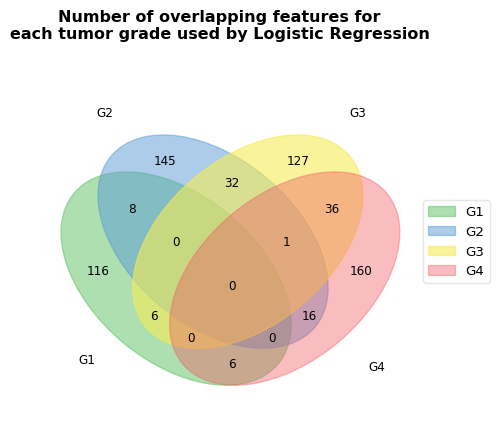

In [ ]:
labs = venn.get_labels(select_features_grade, fill='number')
fig, ax = venn.venn4(labs, names=sorted(np.unique(metadata.tumor_grade)), 
                     figsize=(10,5), fontsize=9)
fig.suptitle('Number of overlapping features for\neach tumor grade used by Logistic Regression', fontweight='bold');

In [104]:
def get_overlap_genes(genes, name='G1', other_grades=['G2', 'G3']):
    grade_map = {'G1':0, 'G2':1, 'G3':2, 'G4':3}
    
    # get genes of grade of interest
    grade_of_interest = set(genes[grade_map[name]])
    for i in other_grades:
        res = grade_of_interest.intersection(set(genes[grade_map[i]]))

    return(sorted(res))

In [107]:
get_overlap_genes(select_features_grade, 'G1', ['G2']), get_overlap_genes(select_features_grade, 'G1', ['G2', 'G3'])

(['CDX2', 'CLEC4E', 'DHRS7C', 'DKKL1', 'NFKBID', 'PTPRZ1', 'SLC43A1', 'STX11'],
 ['ABCA8', 'CHST3', 'CLIC5', 'MMAA', 'PDYN', 'ZNF524'])

In [109]:
get_overlap_genes(select_features_grade, 'G1', ['G2', 'G3'])

['ABCA8', 'CHST3', 'CLIC5', 'MMAA', 'PDYN', 'ZNF524']

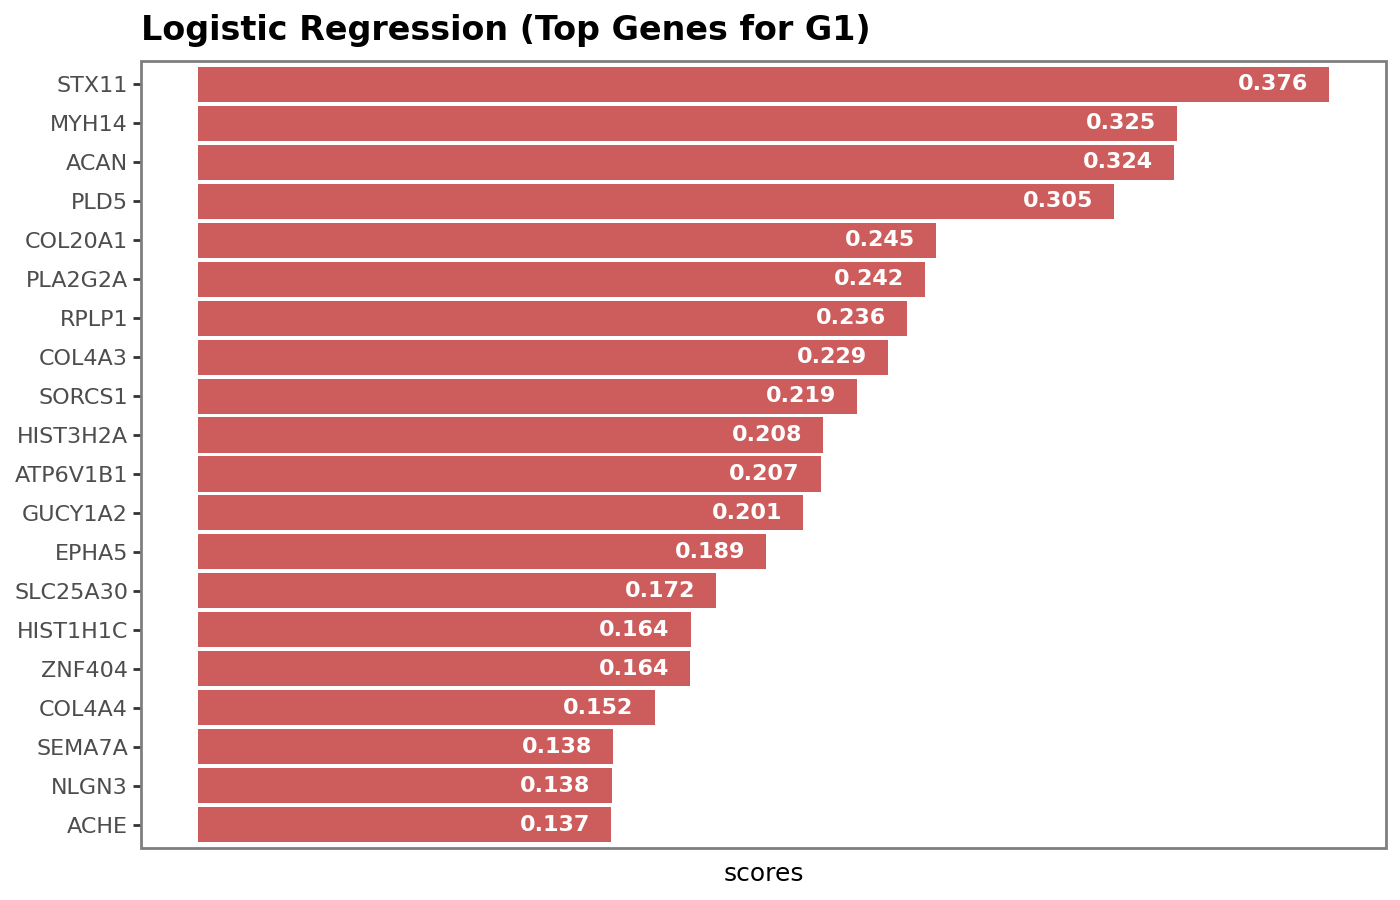

In [110]:
topn_importance(lr, coef_num=0) + pn.labs(title='Logistic Regression (Top Genes for G1)')

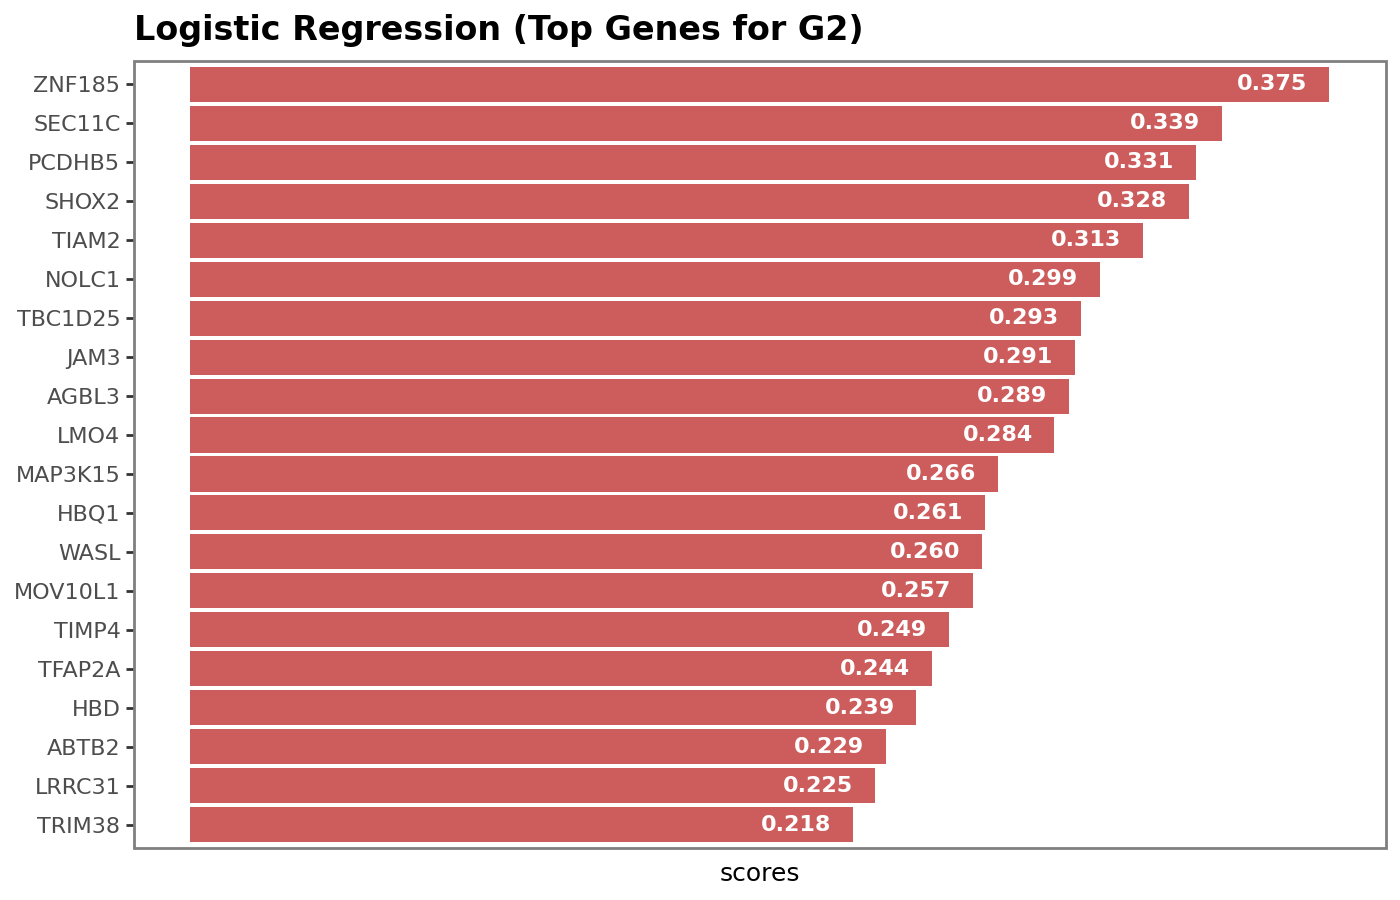

In [111]:
topn_importance(lr, coef_num=1) + pn.labs(title='Logistic Regression (Top Genes for G2)')

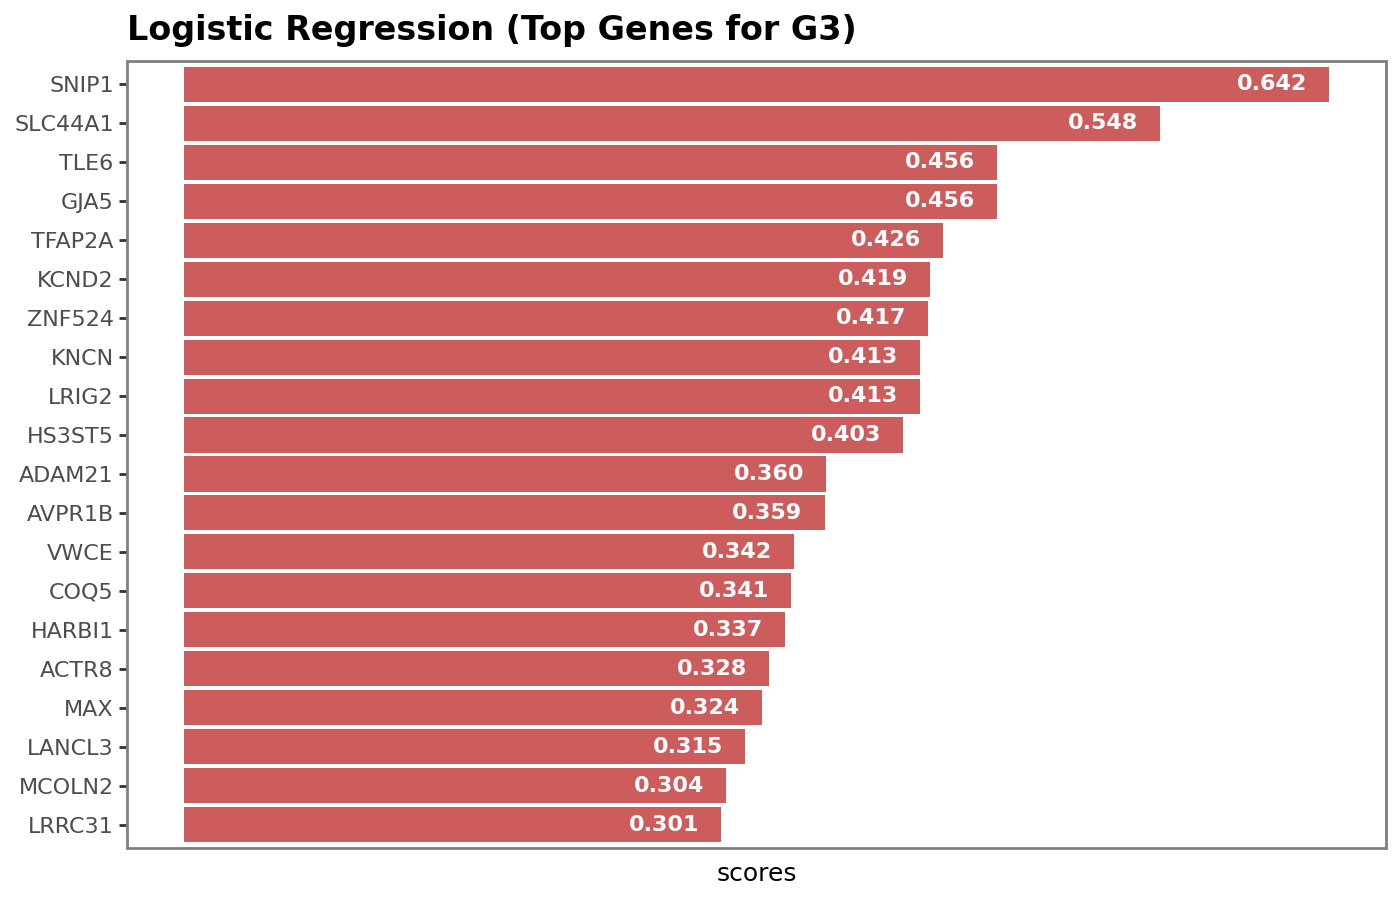

In [112]:
topn_importance(lr, coef_num=2) + pn.labs(title='Logistic Regression (Top Genes for G3)')

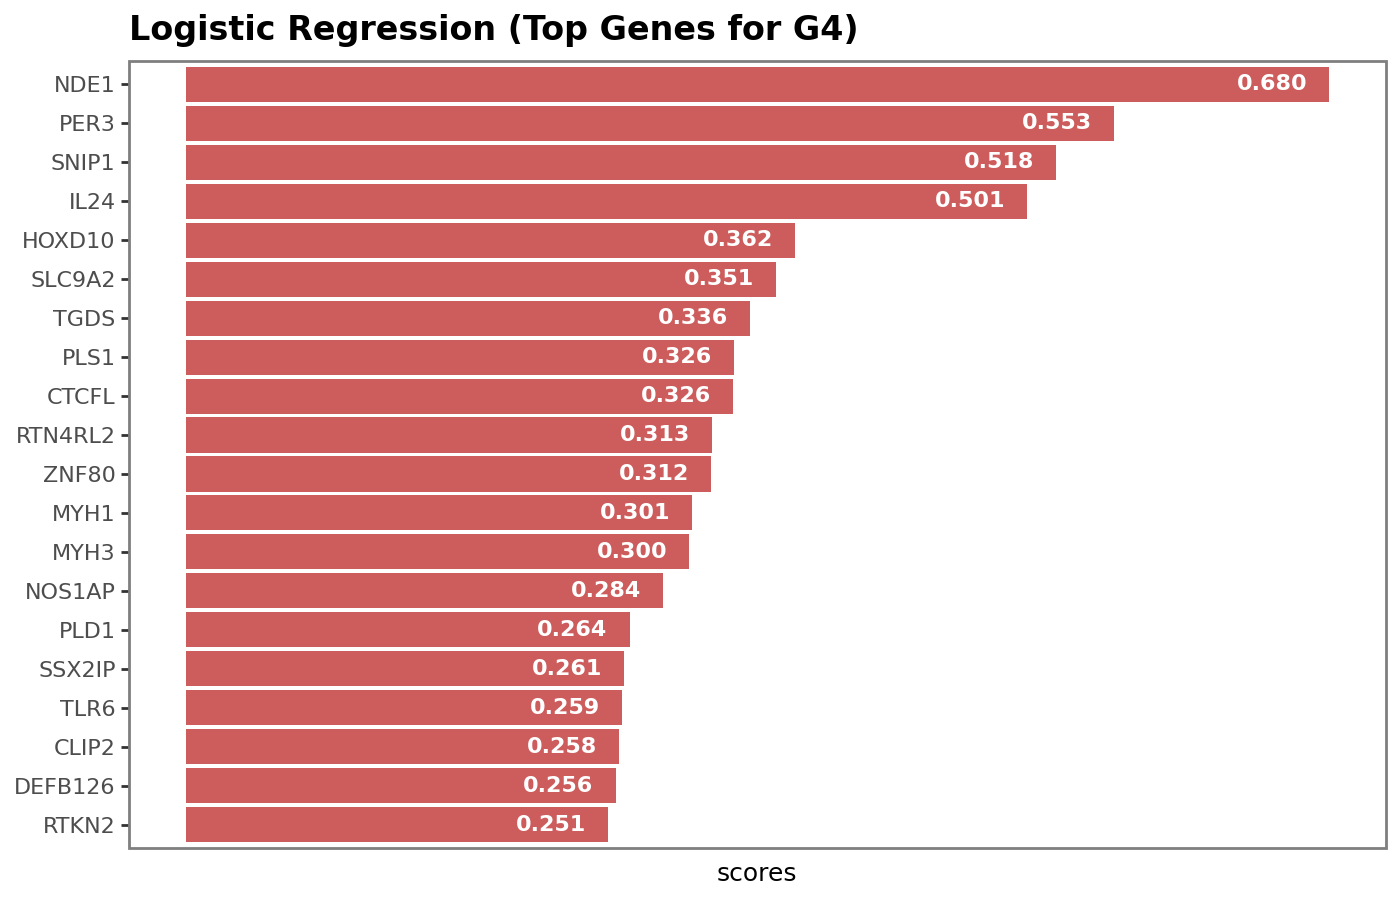

In [113]:
topn_importance(lr, coef_num=3) + pn.labs(title='Logistic Regression (Top Genes for G4)')

In [114]:
print(eval_metrics(lr, xtest_scaled, ytest, average_type='macro'))

        Accuracy       AUC    Recall  Precision        F1  Specificity
scores  0.868132  0.968031  0.846581   0.870587  0.849986     0.957585


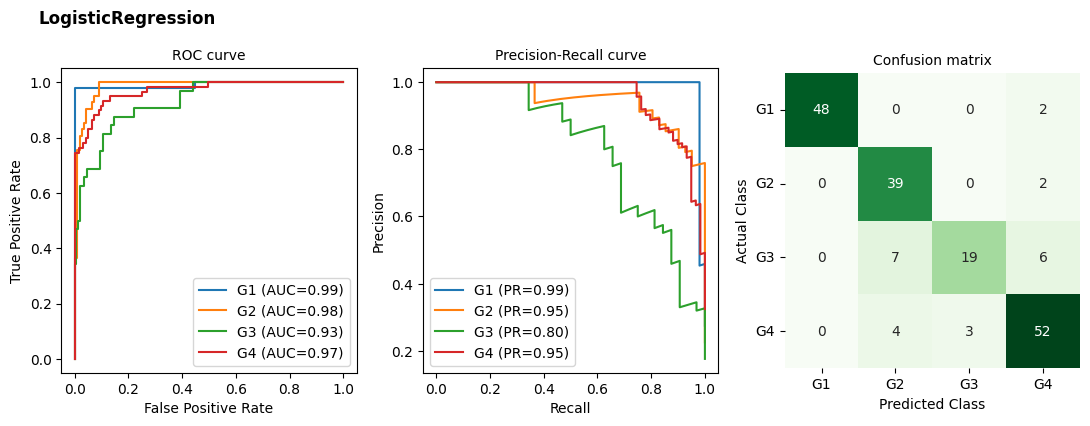

In [115]:
performance_chart_report(lr, xtest_scaled, ytest)

In [116]:
print_classification_report(lr, xtest_scaled, ytest)

              precision    recall  f1-score   support

          G1       1.00      0.96      0.98        50
          G2       0.78      0.95      0.86        41
          G3       0.86      0.59      0.70        32
          G4       0.84      0.88      0.86        59

    accuracy                           0.87       182
   macro avg       0.87      0.85      0.85       182
weighted avg       0.87      0.87      0.86       182



__Random Forest Model__

We will recursively run a random forest model to drop features that are zero and below

In [117]:
rf = RandomForestClassifier(random_state=42)

In [118]:
rf.fit(xtrain, ytrain)

var_imp = pd.Series(rf.feature_importances_, 
                    index=rf.feature_names_in_)

In [119]:
while any(var_imp <= 0):
    temp_features = var_imp[var_imp > 0].index.tolist()
    rf.fit(xtrain[temp_features], ytrain)
    
    var_imp = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)

    if all(var_imp > 0):
        break

In [120]:
# confirm if all importance scores are greater than 0
print(all(var_imp > 0))

print(len(temp_features)) # num of selected features

True
749


In [ ]:
rf_params = {
    'n_estimators' : [200, 500],
    'max_features' : [0.05, 0.1, 0.2],
    'min_samples_split' : [2,5,7],
    'min_samples_leaf' : [1,2,7]
}

In [641]:
rf_res = tune_parameters(rf, xtrain[temp_features], ytrain, rf_params)

In [642]:
rf_res.best_params_, rf_res.best_score_

({'max_features': 0.2,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 500},
 0.979271251909956)

In [165]:
rf = rf.set_params(**{
    'max_features': 0.2,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 400
    },)

In [166]:
# fit with selected features
rf.fit(xtrain[temp_features], ytrain)

RandomForestClassifier(max_features=0.2, min_samples_leaf=2, n_estimators=400,
                       random_state=42)

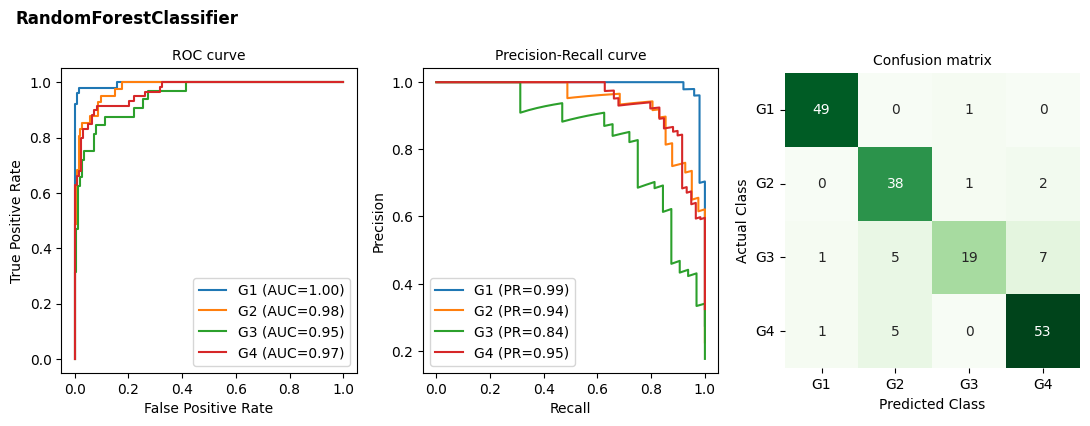

In [167]:
performance_chart_report(rf, xtest[temp_features], ytest)

In [168]:
eval_metrics(rf, xtest[temp_features], ytest)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.873626,0.974436,0.873626,0.878491,0.868986,0.962454


In [169]:
print_classification_report(rf, xtest[temp_features], ytest)

              precision    recall  f1-score   support

          G1       0.96      0.98      0.97        50
          G2       0.79      0.93      0.85        41
          G3       0.90      0.59      0.72        32
          G4       0.85      0.90      0.88        59

    accuracy                           0.87       182
   macro avg       0.88      0.85      0.85       182
weighted avg       0.88      0.87      0.87       182



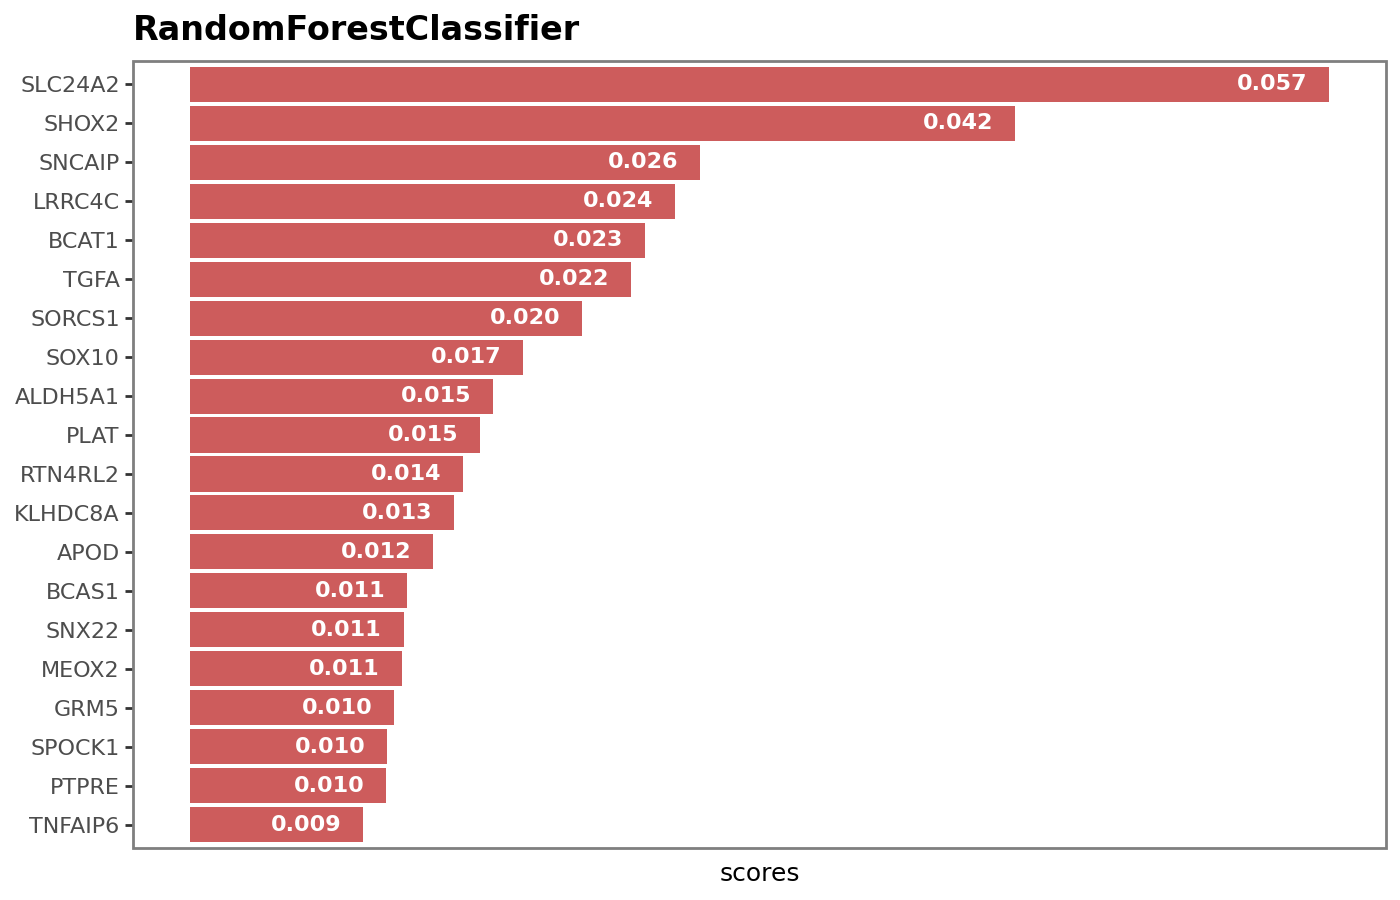

In [170]:
topn_importance(rf)

__Common features selected by both logistic regression and random forests models__

In [171]:
common_genes = list(set(temp_features).intersection(f))
print(len(sorted(common_genes)))

145


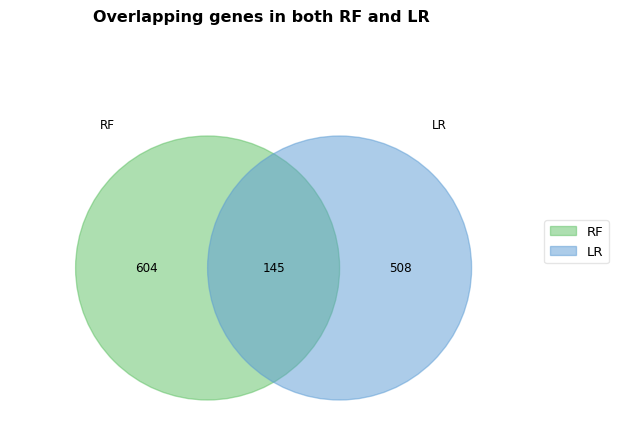

In [176]:
labs = venn.get_labels([temp_features, f], fill='number')
fig, ax = venn.venn2(labs, names=('RF', 'LR'), 
                     figsize=(10,5), fontsize=9)
fig.suptitle('Overlapping genes in both RF and LR', fontweight='bold');

### Feature Decompostion to reduce the number of features

- LDA

In [209]:
lda = LinearDiscriminantAnalysis()
lda.fit(xtrain, ytrain)
print(eval_metrics(lda, xtest, ytest))

        Accuracy       AUC    Recall  Precision        F1  Specificity
scores  0.807692  0.938167  0.807692    0.81728  0.811342     0.940876


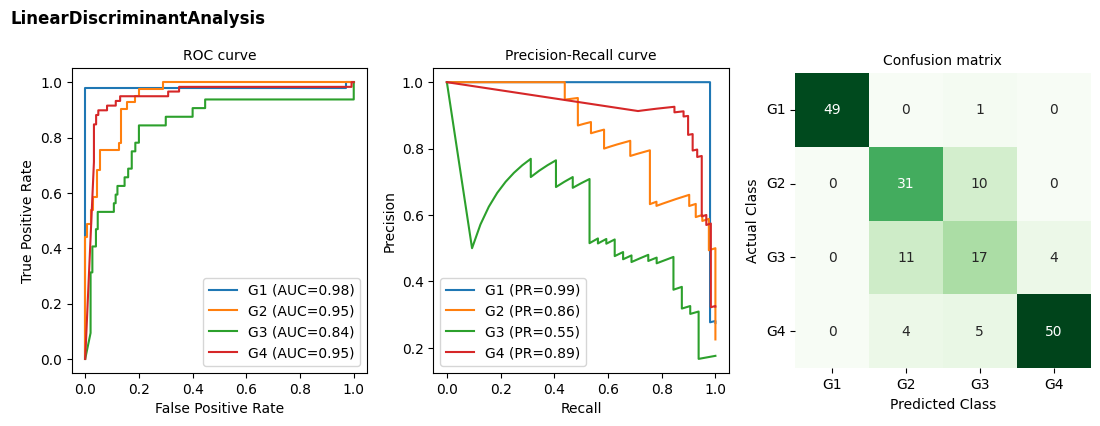

In [208]:
performance_chart_report(lda, xtest, ytest)

In [184]:
print_classification_report(lda, xtest, ytest)

              precision    recall  f1-score   support

          G1       1.00      0.98      0.99        50
          G2       0.67      0.76      0.71        41
          G3       0.52      0.53      0.52        32
          G4       0.93      0.85      0.88        59

    accuracy                           0.81       182
   macro avg       0.78      0.78      0.78       182
weighted avg       0.82      0.81      0.81       182



- PCA + kNN

In [ ]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('scaler2', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [189]:
knn_params = {
    'pca__n_components' : np.arange(0.6,1,0.05),
    'knn__n_neighbors' : np.arange(3,15,2)
}

In [192]:
knn_res = tune_parameters(knn_pipe, xtrain, ytrain, knn_params)

In [195]:
knn_res.best_params_, knn_res.best_score_

({'knn__n_neighbors': 7, 'pca__n_components': 0.6}, 0.9078349692294629)

In [196]:
knn_res.cv_results_['mean_test_score']

array([0.88485654, 0.87780466, 0.88778162, 0.87561719, 0.84558255,
       0.82717116, 0.79753119, 0.76031525, 0.90447814, 0.88911122,
       0.89576945, 0.88675732, 0.87117569, 0.84508312, 0.81639277,
       0.78147426, 0.90783497, 0.89311721, 0.9035239 , 0.89486422,
       0.87869935, 0.85380857, 0.82807132, 0.78581787, 0.90756763,
       0.8963627 , 0.90308448, 0.89338163, 0.88351623, 0.85881304,
       0.83217147, 0.79321106, 0.9041175 , 0.90093262, 0.90541395,
       0.8954535 , 0.88208779, 0.86251817, 0.83564502, 0.79506879,
       0.90677857, 0.9066311 , 0.90769891, 0.8964732 , 0.87837022,
       0.86484986, 0.83617106, 0.78087108])

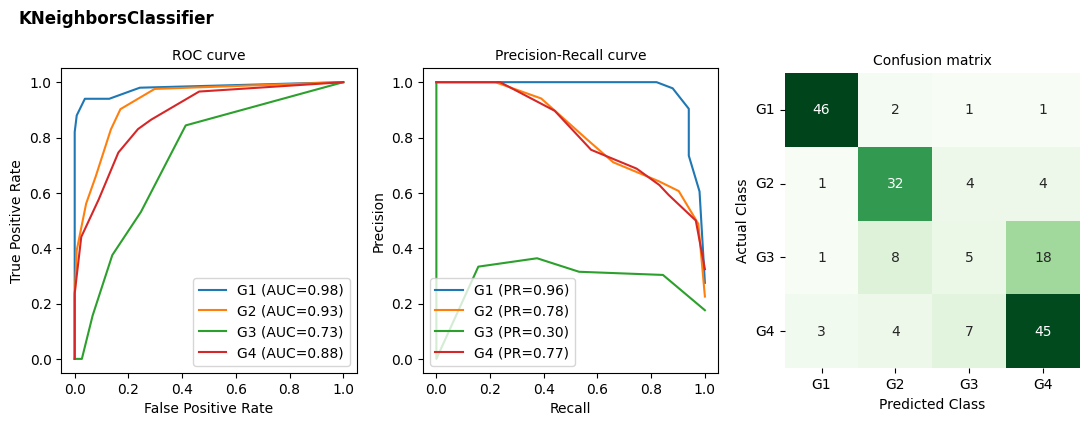

In [204]:
performance_chart_report(knn_res.best_estimator_, xtest, ytest) 
plt.suptitle('KNeighborsClassifier', x=0.11, fontweight='bold');